Generating molecular features...
Feature vector size: 1204

Training model for: Hepatobiliary disorders
ROC-AUC: 0.7257
              precision    recall  f1-score   support

           0       0.60      0.61      0.60       120
           1       0.71      0.70      0.71       166

    accuracy                           0.66       286
   macro avg       0.66      0.66      0.66       286
weighted avg       0.67      0.66      0.66       286


Training model for: Metabolism and nutrition disorders
ROC-AUC: 0.5656
              precision    recall  f1-score   support

           0       0.39      0.25      0.31        79
           1       0.75      0.85      0.80       207

    accuracy                           0.69       286
   macro avg       0.57      0.55      0.55       286
weighted avg       0.65      0.69      0.66       286


Training model for: Product issues
ROC-AUC: 0.5100
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    

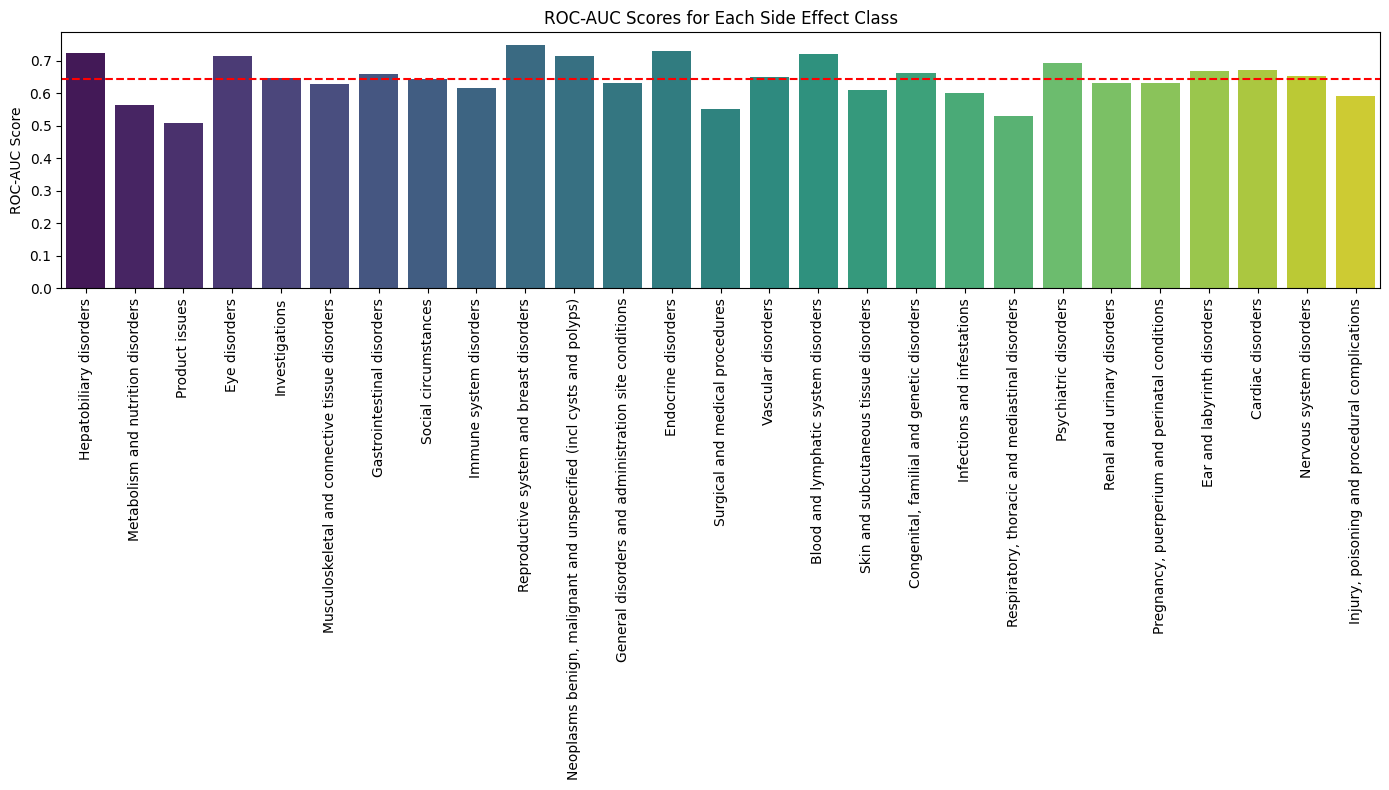


Mean ROC-AUC: 0.6448
Median ROC-AUC: 0.6462
Min ROC-AUC: 0.5100 (Product issues)
Max ROC-AUC: 0.7505 (Reproductive system and breast disorders)


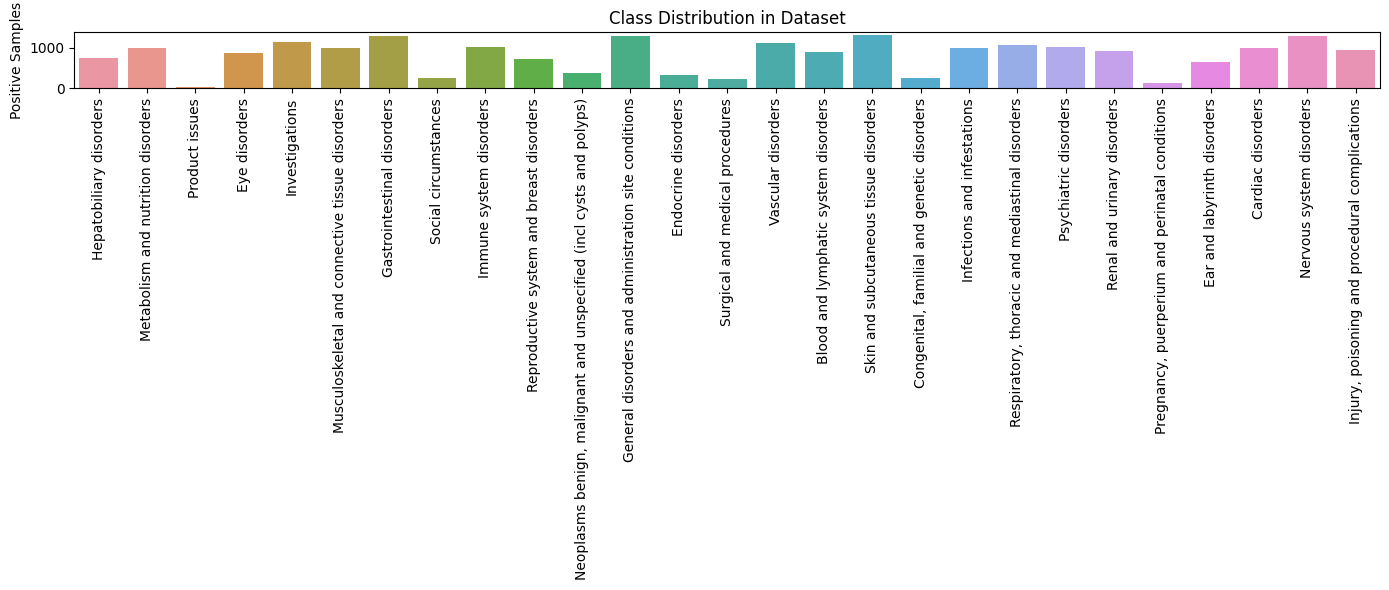

In [16]:
# !pip install datasets rdkit numpy pandas xgboost seaborn scikit-learn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Descriptors, MACCSkeys
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem import rdFingerprintGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report
from xgboost import XGBClassifier
import seaborn as sns
import warnings

# Suppress RDKit warnings
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')
warnings.filterwarnings('ignore')

# Load dataset
ds = load_dataset("HUBioDataLab/sider")
ds = ds["train"].train_test_split(test_size=0.2)
train_df = ds["train"].to_pandas()
test_df = ds["test"].to_pandas()

# Combine train and test for preprocessing
full_df = pd.concat([train_df, test_df])

# Generate comprehensive molecular descriptors
def smiles_to_features(smiles):
    """Generate comprehensive molecular features from SMILES"""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    features = []

    # 1. Morgan Fingerprints (using new GetMorganGenerator)
    morgan_gen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=1024)
    morgan_fp = morgan_gen.GetFingerprint(mol)
    morgan_arr = np.zeros((1024,))
    DataStructs.ConvertToNumpyArray(morgan_fp, morgan_arr)
    features.extend(morgan_arr)

    # 2. MACCS Keys (166 bits)
    maccs = MACCSkeys.GenMACCSKeys(mol)
    maccs_arr = np.zeros((167,))  # MACCS has 167 keys (0-166)
    DataStructs.ConvertToNumpyArray(maccs, maccs_arr)
    features.extend(maccs_arr[1:])  # Skip first bit (always 0)

    # 3. Essential Molecular Descriptors (reduced to most important for ADMET)
    desc_list = [
        Descriptors.MolWt(mol),              # Molecular weight
        Descriptors.MolLogP(mol),            # LogP (lipophilicity)
        Descriptors.NumHDonors(mol),         # Hydrogen bond donors
        Descriptors.NumHAcceptors(mol),      # Hydrogen bond acceptors
        Descriptors.NumRotatableBonds(mol),  # Rotatable bonds
        Descriptors.TPSA(mol),               # Topological polar surface area
        Descriptors.NumAromaticRings(mol),   # Aromatic rings
        Descriptors.NumSaturatedRings(mol),  # Saturated rings
        Descriptors.RingCount(mol),          # Total rings
        Descriptors.NumHeteroatoms(mol),     # Heteroatoms
        Descriptors.BertzCT(mol),            # Molecular complexity
        Descriptors.HallKierAlpha(mol),      # Flexibility index
        Descriptors.LabuteASA(mol),          # Accessible surface area
        Descriptors.MaxAbsEStateIndex(mol)   # Electrotopological state
    ]

    # Handle NaN values in descriptors
    desc_list = [0.0 if pd.isna(x) else x for x in desc_list]
    features.extend(desc_list)

    return np.array(features)

# Process SMILES strings
print("Generating molecular features...")
full_df['features'] = full_df['smiles'].apply(smiles_to_features)
full_df = full_df.dropna(subset=['features'])

print(f"Feature vector size: {len(full_df['features'].iloc[0])}")

# Split back into train/test
train_size = len(train_df)
X = np.stack(full_df['features'].values)
y = full_df.drop(columns=['smiles', 'features']).values.astype(int)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Get target names
target_names = [col for col in train_df.columns if col != 'smiles']

# Train XGBoost models and evaluate
auc_scores = []
reports = []

for i, target in enumerate(target_names):
    print(f"\nTraining model for: {target}")
    
    # Train XGBoost classifier
    model = XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )
    model.fit(X_train, y_train[:, i])
    
    # Predict probabilities
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate AUC
    auc = roc_auc_score(y_test[:, i], y_pred_proba)
    auc_scores.append(auc)
    
    # Generate classification report
    y_pred = model.predict(X_test)
    report = classification_report(
        y_test[:, i], 
        y_pred,
        target_names=['Negative', 'Positive'],
        output_dict=True
    )
    reports.append(report)
    
    print(f"ROC-AUC: {auc:.4f}")
    print(classification_report(y_test[:, i], y_pred))

# Plot AUC scores
plt.figure(figsize=(14, 8))
sns.barplot(x=target_names, y=auc_scores, palette='viridis')
plt.axhline(np.mean(auc_scores), color='red', linestyle='--')
plt.xticks(rotation=90)
plt.ylabel('ROC-AUC Score')
plt.title('ROC-AUC Scores for Each Side Effect Class')
plt.tight_layout()
plt.savefig('auc_scores.png')
plt.show()

# Print summary statistics
print("\n" + "="*60)
print(f"Mean ROC-AUC: {np.mean(auc_scores):.4f}")
print(f"Median ROC-AUC: {np.median(auc_scores):.4f}")
print(f"Min ROC-AUC: {min(auc_scores):.4f} ({target_names[auc_scores.index(min(auc_scores))]})")
print(f"Max ROC-AUC: {max(auc_scores):.4f} ({target_names[auc_scores.index(max(auc_scores))]})")
print("="*60)

# Plot class distribution
class_counts = y.sum(axis=0)
plt.figure(figsize=(14, 6))
sns.barplot(x=target_names, y=class_counts)
plt.xticks(rotation=90)
plt.ylabel('Positive Samples')
plt.title('Class Distribution in Dataset')
plt.tight_layout()
plt.savefig('class_distribution.png')
plt.show()



data.csv:   0%|          | 0.00/459k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7831 [00:00<?, ? examples/s]

Generating molecular features...
Feature vector size: 1204

Training model for: NR-AR
ROC-AUC: 0.7962
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98      1372
         1.0       0.83      0.39      0.53        61

    accuracy                           0.97      1433
   macro avg       0.90      0.69      0.76      1433
weighted avg       0.97      0.97      0.97      1433


Training model for: NR-AR-LBD
ROC-AUC: 0.8458
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      1305
         1.0       0.79      0.52      0.63        42

    accuracy                           0.98      1347
   macro avg       0.89      0.76      0.81      1347
weighted avg       0.98      0.98      0.98      1347


Training model for: NR-AhR
ROC-AUC: 0.9012
              precision    recall  f1-score   support

         0.0       0.93      0.98      0.96      1134
         1.0       0.80      0.51      0.62 

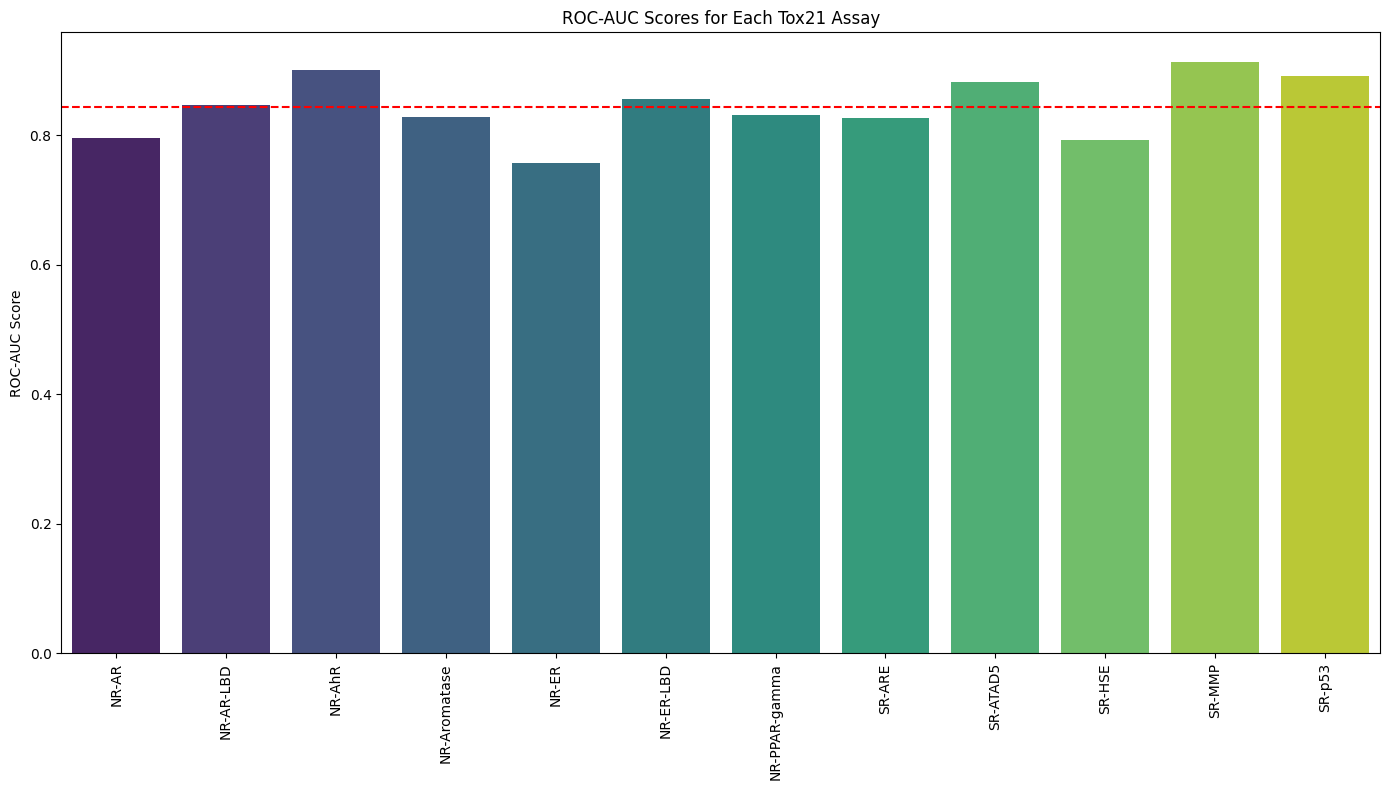


Mean ROC-AUC: 0.8435
Median ROC-AUC: 0.8382
Min ROC-AUC: 0.7573 (NR-ER)
Max ROC-AUC: 0.9130 (SR-MMP)


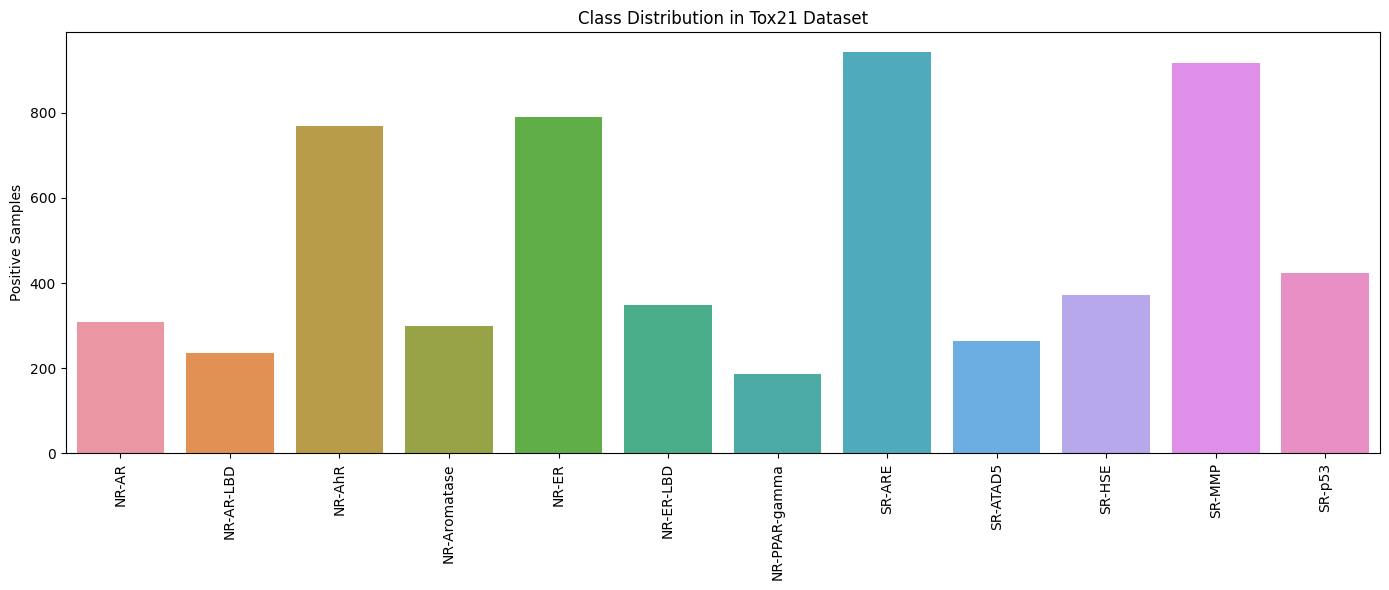

In [17]:
# !pip install datasets rdkit numpy pandas xgboost seaborn scikit-learn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Descriptors, MACCSkeys
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem import rdFingerprintGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report
from xgboost import XGBClassifier
import seaborn as sns
import warnings

# Suppress RDKit warnings
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')
warnings.filterwarnings('ignore')

# Load Tox21 dataset
ds = load_dataset("HUBioDataLab/tox21")
# Convert to pandas and split into train/test
full_df = ds["train"].to_pandas()
train_df, test_df = train_test_split(full_df, test_size=0.2, random_state=42)

# Combine train and test for preprocessing
full_df = pd.concat([train_df, test_df])

# Generate comprehensive molecular descriptors
def smiles_to_features(smiles):
    """Generate comprehensive molecular features from SMILES"""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    features = []

    # 1. Morgan Fingerprints (using new GetMorganGenerator)
    morgan_gen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=1024)
    morgan_fp = morgan_gen.GetFingerprint(mol)
    morgan_arr = np.zeros((1024,))
    DataStructs.ConvertToNumpyArray(morgan_fp, morgan_arr)
    features.extend(morgan_arr)

    # 2. MACCS Keys (166 bits)
    maccs = MACCSkeys.GenMACCSKeys(mol)
    maccs_arr = np.zeros((167,))  # MACCS has 167 keys (0-166)
    DataStructs.ConvertToNumpyArray(maccs, maccs_arr)
    features.extend(maccs_arr[1:])  # Skip first bit (always 0)

    # 3. Essential Molecular Descriptors (reduced to most important for ADMET)
    desc_list = [
        Descriptors.MolWt(mol),              # Molecular weight
        Descriptors.MolLogP(mol),            # LogP (lipophilicity)
        Descriptors.NumHDonors(mol),         # Hydrogen bond donors
        Descriptors.NumHAcceptors(mol),      # Hydrogen bond acceptors
        Descriptors.NumRotatableBonds(mol),  # Rotatable bonds
        Descriptors.TPSA(mol),               # Topological polar surface area
        Descriptors.NumAromaticRings(mol),   # Aromatic rings
        Descriptors.NumSaturatedRings(mol),  # Saturated rings
        Descriptors.RingCount(mol),          # Total rings
        Descriptors.NumHeteroatoms(mol),     # Heteroatoms
        Descriptors.BertzCT(mol),            # Molecular complexity
        Descriptors.HallKierAlpha(mol),      # Flexibility index
        Descriptors.LabuteASA(mol),          # Accessible surface area
        Descriptors.MaxAbsEStateIndex(mol)   # Electrotopological state
    ]

    # Handle NaN values in descriptors
    desc_list = [0.0 if pd.isna(x) else x for x in desc_list]
    features.extend(desc_list)

    return np.array(features)

# Process SMILES strings
print("Generating molecular features...")
full_df['features'] = full_df['smiles'].apply(smiles_to_features)
full_df = full_df.dropna(subset=['features'])

print(f"Feature vector size: {len(full_df['features'].iloc[0])}")

# Split back into train/test
train_size = len(train_df)
X = np.stack(full_df['features'].values)
y = full_df.drop(columns=['smiles', 'features']).values.astype(float)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Get target names (Tox21 assays)
target_names = [col for col in train_df.columns if col != 'smiles']

# Train XGBoost models and evaluate
auc_scores = []
reports = []

for i, target in enumerate(target_names):
    print(f"\nTraining model for: {target}")
    
    # Skip targets with all NaN values
    if np.all(np.isnan(y_train[:, i])) or np.all(np.isnan(y_test[:, i])):
        print(f"Skipping {target} - all NaN values")
        auc_scores.append(np.nan)
        reports.append(None)
        continue
    
    # Remove NaN values for this target
    train_mask = ~np.isnan(y_train[:, i])
    test_mask = ~np.isnan(y_test[:, i])
    
    if np.sum(train_mask) == 0 or np.sum(test_mask) == 0:
        print(f"Skipping {target} - insufficient data")
        auc_scores.append(np.nan)
        reports.append(None)
        continue
    
    X_train_clean = X_train[train_mask]
    y_train_clean = y_train[train_mask, i]
    X_test_clean = X_test[test_mask]
    y_test_clean = y_test[test_mask, i]
    
    # Train XGBoost classifier
    model = XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )
    model.fit(X_train_clean, y_train_clean)
    
    # Predict probabilities
    y_pred_proba = model.predict_proba(X_test_clean)[:, 1]
    
    # Calculate AUC
    auc = roc_auc_score(y_test_clean, y_pred_proba)
    auc_scores.append(auc)
    
    # Generate classification report
    y_pred = model.predict(X_test_clean)
    report = classification_report(
        y_test_clean, 
        y_pred,
        target_names=['Negative', 'Positive'],
        output_dict=True
    )
    reports.append(report)
    
    print(f"ROC-AUC: {auc:.4f}")
    print(classification_report(y_test_clean, y_pred))

# Filter out NaN scores for plotting
valid_scores = [(name, score) for name, score in zip(target_names, auc_scores) if not np.isnan(score)]
valid_target_names, valid_auc_scores = zip(*valid_scores) if valid_scores else ([], [])

# Plot AUC scores
if valid_auc_scores:
    plt.figure(figsize=(14, 8))
    sns.barplot(x=list(valid_target_names), y=list(valid_auc_scores), palette='viridis')
    plt.axhline(np.mean(valid_auc_scores), color='red', linestyle='--')
    plt.xticks(rotation=90)
    plt.ylabel('ROC-AUC Score')
    plt.title('ROC-AUC Scores for Each Tox21 Assay')
    plt.tight_layout()
    plt.savefig('tox21_auc_scores.png')
    plt.show()

    # Print summary statistics
    print("\n" + "="*60)
    print(f"Mean ROC-AUC: {np.mean(valid_auc_scores):.4f}")
    print(f"Median ROC-AUC: {np.median(valid_auc_scores):.4f}")
    print(f"Min ROC-AUC: {min(valid_auc_scores):.4f} ({valid_target_names[valid_auc_scores.index(min(valid_auc_scores))]})")
    print(f"Max ROC-AUC: {max(valid_auc_scores):.4f} ({valid_target_names[valid_auc_scores.index(max(valid_auc_scores))]})")
    print("="*60)

# Plot class distribution (handling NaN values)
class_counts = []
for i, target in enumerate(target_names):
    valid_mask = ~np.isnan(y[:, i])
    if np.sum(valid_mask) > 0:
        count = np.sum(y[valid_mask, i] == 1)
    else:
        count = 0
    class_counts.append(count)

plt.figure(figsize=(14, 6))
sns.barplot(x=target_names, y=class_counts)
plt.xticks(rotation=90)
plt.ylabel('Positive Samples')
plt.title('Class Distribution in Tox21 Dataset')
plt.tight_layout()
plt.savefig('tox21_class_distribution.png')
plt.show()
